# Internet Ad Classification Practice

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import scipy.stats as stat
from sklearn import preprocessing


In [2]:
df=pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/internet_ads/ad.data", low_memory=False,header=None)

In [3]:
df.columns=df.columns.astype('str')

In [4]:
df.rename(columns={'1558': 'ad'}, inplace=True)

In [5]:
df.iloc[:,0].describe()

count     3279
unique     221
top          ?
freq       903
Name: 0, dtype: object

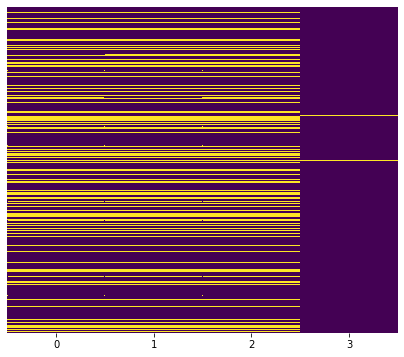

In [6]:
# indentifying the missing values '?' in dataset

newdf=df.iloc[:,[0,1,2,3]]
newdf=newdf.applymap(lambda x: '?' in x)
plt.figure(figsize=(7,6))
sns.heatmap(newdf, cbar=False, yticklabels=False, cmap='viridis')

In [7]:
for i in (newdf):
    print('column['+str(i)+'] has missing values -'+str(sum(newdf[i])))

column[0] has missing values -903
column[1] has missing values -901
column[2] has missing values -910
column[3] has missing values -15


In [8]:
def replace_missing(df):
    for i in df:
        df[i] = df[i].replace('[?]', np.NAN, regex=True).astype('float') #go to column, replace the ? with nan and make it a number data type
        df[i] = df[i].fillna(df[i].mean()) # replace the na with the mean of that column
    return df

In [9]:
df.columns=df.columns.astype(str).str.lower()

In [10]:
df[['0','1','2','3']]=replace_missing(df[['0','1','2','3']].copy()).values

In [11]:
df[['3']]=df[['3']].apply(lambda x: round(x))

In [12]:
df[['0','1','2','3']].describe()

,0,1,2,3
count,3279.000000,3279.000000,3279.000000,3279.000000
mean,64.021886,155.344828,3.911953,0.768222
std,46.703695,110.729038,5.136153,0.422032
min,1.000000,1.000000,0.001500,0.000000
25%,32.500000,90.000000,1.279400,1.000000
50%,64.021886,150.000000,3.911953,1.000000
75%,64.021886,155.344828,3.911953,1.000000
max,640.000000,640.000000,60.000000,1.000000


### Looking at distributions of the first three variables

In [13]:
df.rename(columns={'0': 'img_height', '1': 'img_wdith','2':'aspect_ratio'}, inplace=True)

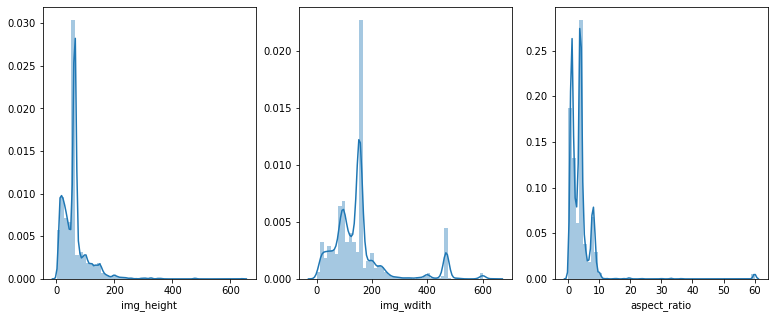

In [14]:
fig, ax = plt.subplots(1,3)

fig.set_figheight(5)
fig.set_figwidth(13)

plt.subplot(1,3,1)
sns.distplot(pd.Series(df['img_height']))
plt.subplot(1,3,2)
sns.distplot(pd.Series(df['img_wdith']))
plt.subplot(1,3,3)
sns.distplot(pd.Series(df['aspect_ratio']));

- Positively skewed distributions

Examining relationships between the variables:

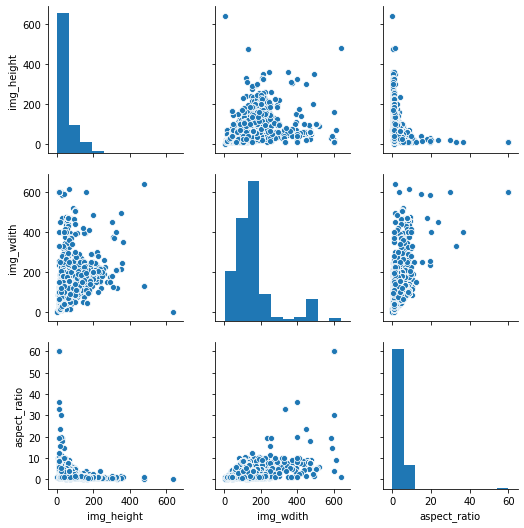

In [15]:
sns.pairplot(data=df.loc[:,['img_height','img_wdith','aspect_ratio']])

Looking at these specifically in context of ad and not ad

In [16]:
df.head()

,img_height,img_wdith,aspect_ratio,3,4,5,6,7,8,9,...,1549,1550,1551,1552,1553,1554,1555,1556,1557,ad
0,125.0,125.0,1.0000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
1,57.0,468.0,8.2105,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
2,33.0,230.0,6.9696,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
3,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
4,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.


In [17]:
# encoding ad. and nonad.
df.iloc[:,-1] = df.iloc[:,-1].replace(['ad.','nonad.'], [1,0])

In [18]:
df['ad'].mean() # only 14% of the observations are ads
# See below in modeling section for handling this

0.13998170173833485

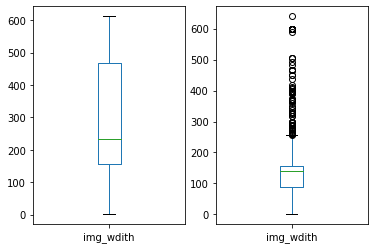

In [19]:
plt.subplot(1,2,1)
df.loc[df['ad'] == 1].img_wdith.plot.box()

plt.subplot(1,2,2)
df.loc[df['ad'] == 0].img_wdith.plot.box();

# Model Prep

In [20]:
x = df.iloc[:,:-1]
y=df.iloc[:,-1]

### Best practice: scaling the data to normal distribution using z scores

In [21]:
from sklearn.preprocessing import StandardScaler

scaled = StandardScaler()
x=scaled.fit_transform(x)

C:\Users\pdilm\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\pdilm\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


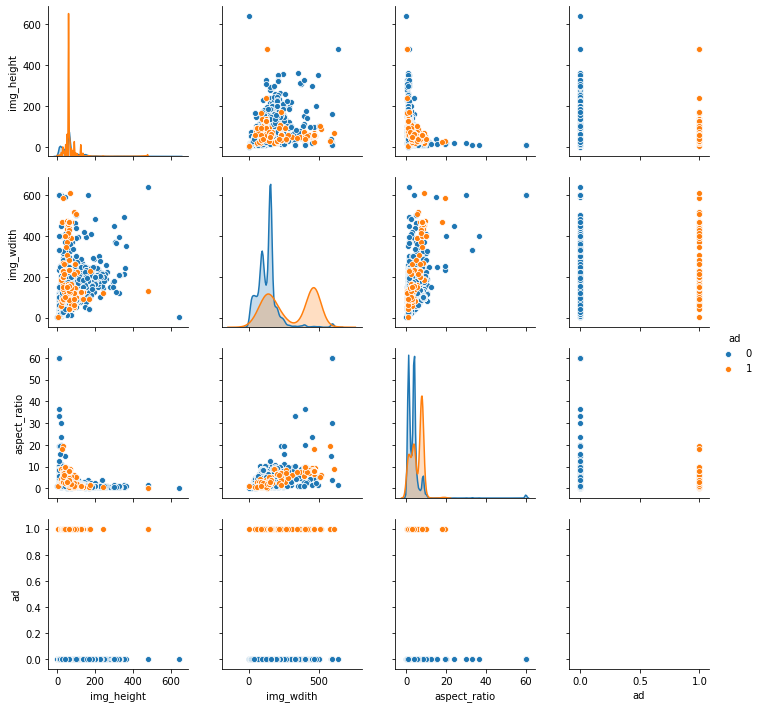

In [22]:
sns.pairplot(data=df.iloc[:,[0,1,2,-1]], hue='ad')

# Modeling yay!

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [24]:
x_train, x_test, y_train, y_test = train_test_split(np.array(x), np.array(y), test_size=0.33, random_state=42)

### Fixing the minority sample of ads artificially

In [32]:
from imblearn.over_sampling import SMOTE # synthetic minority oversampling technique = articifically balancing out observations of the minority group by drawing feature vectors are creating new but similar observations
os= SMOTE(random_state=42)
from sklearn import metrics

In [28]:
columns=pd.DataFrame(x_train).columns
os_data_x,os_data_y=os.fit_sample(x_train, y_train)
os_data_X = pd.DataFrame(data=os_data_x,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])

In [29]:
print("length of oversampled data is ",len(os_data_x))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_x))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_x))

length of oversampled data is  3808
Number of no subscription in oversampled data 1904
Number of subscription 1904
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [33]:
logreg=LogisticRegression()

In [52]:
X = os_data_X
y = os_data_y

In [53]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state =42)

In [54]:
logreg.fit(x_train, y_train)

C:\Users\pdilm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\pdilm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [55]:
y_pred=logreg.predict(x_test)

In [56]:
logreg.score(x_test,y_test)

0.9746281714785652

In [57]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[562  18]
 [ 11 552]]


- 562+552= 1114 correct classes, 18+11=29 incorrect classes

Precision = not labeling a sample as positive if it is negative. True positive rate.
Recall = True positives/ true positives + false negatives = ability of classifier to find all positive samples.

F-beta is the 'harmoninc mean' between the precision and recall. It is best at 1, and worst value at 0. F-beta weights the recall more than the precision by a factor of beta. beta =1 means they're equally important (this will change depending on the classification problem)

Support = number of occurrences of each class in y_test.

In [58]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       580
           1       0.97      0.98      0.97       563

    accuracy                           0.97      1143
   macro avg       0.97      0.97      0.97      1143
weighted avg       0.97      0.97      0.97      1143



In [59]:
from sklearn.metrics import roc_auc_score, roc_curve

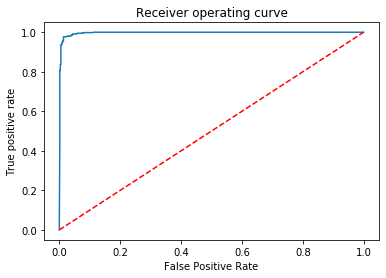

In [65]:
logreg_roc = roc_auc_score(y_test, logreg.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(x_test)[:,1])
plt.figure()

plt.plot(fpr,tpr, label='Logistic regression' % logreg_roc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel("True positive rate")
plt.title("Receiver operating curve");